
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain expected Sea Level Rise at the Site under 3 different scenarios based on Sweet et al. (2017)

    S1 --> Intermediate Low (+0.5m)
    S2 --> Intermediate (+1m)
    S3 --> Intermediate high (+1.5m)

inputs required: 
  * CSV file containing data for the report "Global and Regional Sea Level Rise Scenarios for the United States" (techrpt083.csv). Data are at different spatial scales:
      - Global Mean Sea Level
      - Tide Gauges
      - Regional Grid
      
in this notebook:
  * Select projected SLR at closest Tide Gauge for the 3 scenarios
  * Fit SLR to a 2º order polynomial from year 2000 to 2100
  * Interpolate to hourly values
  * Save to a netcdf file
  
  
references:
- Sweet, William & Kopp, Robert & Weaver, Christopher & Obeysekera, Jayantha & Horton, Radley & Thieler, E. & Zervas, Chris. (2017). GLOBAL AND REGIONAL SEA LEVEL RISE SCENARIOS FOR THE UNITED STATES.  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

from teslakit.database import Database
from teslakit.io.aux_nc import StoreBugXdset



## Database and Site parameters

In [2]:
p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('KWAJALEIN_emulator')


# Kwajalein point
lon = -117.17#167.73
lat = 32.71#8.72



# SLR parameters 
Scenarios = ['0.5', '1.0', '1.5']  # '0.3', '0.5', '1.0', '1.5', '2.0', '2.5'
Subscenario = 'MED'                # 'HIGH', 'MED', 'LOW'
location = 'TGs'                   # 'GMSL', 'TGS', 'RegionalGrid'


## Prepare site SLR data

In [3]:
# ------------------------------------------------------------------------
# 1) read excel data (techrpt083.csv) and select site

p_csv = db.paths.site.CLIMATE_CHANGE.slr_csv
data = pd.read_csv(p_csv, skiprows=30)

# Global SL
if location == 'GMSL': 
    site = 'GMSL'
    data_site = data.iloc[:18]

# Regional SL
else: 
    if location == 'TGs':
        data = data.iloc[18:4302]
        
    elif location == 'RegionalGrid':
        data = data.iloc[4302:]

    # find closest point:
    dif_lon = data['Longitude'] - lon
    dif_lat = data['Latitude'] - lat
    dif = np.sqrt(dif_lon**2 + dif_lat**2)

    min_dist = dif.min(skipna=True)
    min_ind = dif.idxmin(skipna=True)

    site = data['Site'].loc[min_ind]
    data_site = data.loc[(data['Site'] == site)]

    print(site)
    print(data_site.T)
    print()


SAN DIEGO
                                   234        235         236        237  \
Site                         SAN DIEGO  SAN DIEGO   SAN DIEGO  SAN DIEGO   
PSMSL ID                           158        158         158        158   
Latitude                         32.71      32.71       32.71      32.71   
Longitude                      -117.17    -117.17     -117.17    -117.17   
Scenario                     0.3 - MED  0.3 - LOW  0.3 - HIGH  0.5 - MED   
Background RSL rate (mm/yr)       0.22       0.09        0.35       0.22   
RSL in 2000 (cm)                     0          0           0          0   
RSL in 2010 (cm)                     3          1           4          3   
RSL in 2020 (cm)                     6          4           9          8   
RSL in 2030 (cm)                    11          7          14         14   
RSL in 2040 (cm)                    15          9          19         18   
RSL in 2050 (cm)                    19         12          25         24   
RS

## Fit SLR

[[0.06182387 0.0758393  0.0914403 ]
 [0.06182443 0.07583999 0.09144113]
 [0.06182499 0.07584067 0.09144196]
 ...
 [0.5235894  1.11086009 1.79042436]
 [0.52359007 1.11086215 1.79042804]
 [0.52359073 1.11086422 1.79043172]]


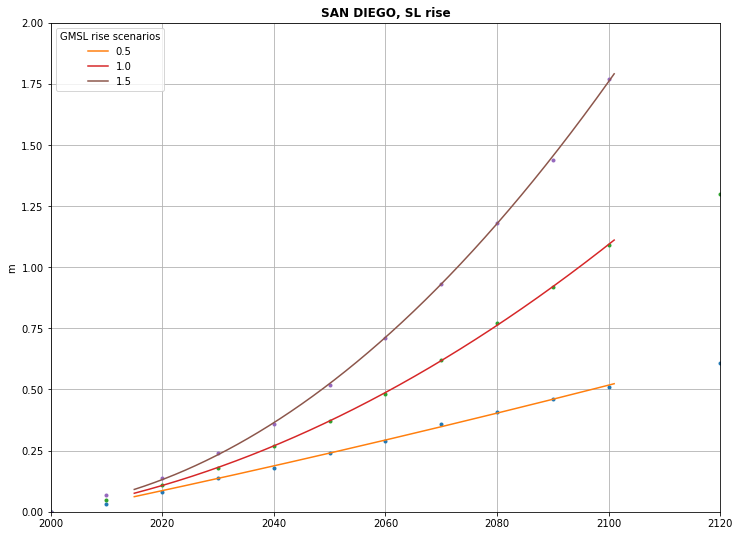

In [4]:
# ------------------------------------------------------------------------
# 2) Fit SLR to a 2º order polynomial

# based on matlab code that Peter's group used to interpolate the 
# Sweet et al. (2017) SLR decadal projection to hourly data

time_axis = np.array(
    ['2000-01-01', '2010-01-01', '2020-01-01', '2030-01-01', '2040-01-01', '2050-01-01', '2060-01-01',
     '2070-01-01', '2080-01-01', '2090-01-01', '2100-01-01', '2120-01-01', '2150-01-01', '2200-01-01'], 
    dtype='datetime64[h]'
)
time_axis_rel = (time_axis - time_axis[0]).astype('int')

# hourly data
#time_axis_H = np.arange('2000-01-01', '2101-01-01', dtype='datetime64[h]')
time_axis_H = np.arange('2015-01-01', '2101-01-01', dtype='datetime64[h]')
time_axis_H_rel = (time_axis_H - time_axis[0]).astype('int')


# prepare figure to show scenarios SLR
fig, ax = plt.subplots(1,1, figsize=(12, 9))


# solve choosen scenarios
y_fit_H = np.zeros((len(time_axis_H), len(Scenarios)))*np.nan

cont = 0
for scenario in Scenarios:
    data_subset = data_site.loc[data_site['Scenario'] == (scenario + ' - ' + Subscenario)]

    y = data_subset.to_numpy()[0][6:]
    y = y.astype('int')
    y = y/100.0  # to meters

    # Fit data, from 2000 to 2100, to a 2º polynomial function  
    coef = np.polyfit(time_axis_rel[:-3], y[:-3], 2)
    
    # Obtain hourly data from the adjusted polynomial function
    y_temp = coef[0]*time_axis_H_rel**2 + coef[1]*time_axis_H_rel + coef[2]
    y_fit_H[:, cont] = y_temp
    cont +=1

    # plot scenario
    ax.plot(time_axis, y, '.', label='')
    ax.plot(time_axis_H, y_temp, label=scenario)
    
print(y_fit_H)


# set figure parameters
ax.set_xlim([time_axis[0], time_axis[-3]])
ax.set_ylim([0, 2])
ax.set_title(site + ', SL rise', fontweight='bold')
ax.set_ylabel('m')
ax.grid()
plt.legend(title='GMSL rise scenarios')

plt.show()


In [5]:
# Export SLR to netCDF4 file

# prepare SLR xarray.Dataset
SLR = xr.Dataset(
    {
        'SLR' : (('time', 'scenario'), y_fit_H)
    },
    
    coords = {
        'time' : time_axis_H,
        'scenario' : Scenarios,
    },
)
print(SLR)

# store it
p_nc = db.paths.site.CLIMATE_CHANGE.slr_nc
StoreBugXdset(SLR, p_nc)


<xarray.Dataset>
Dimensions:   (scenario: 3, time: 753864)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01 ... 2100-12-31T23:00:00
  * scenario  (scenario) <U3 '0.5' '1.0' '1.5'
Data variables:
    SLR       (time, scenario) float64 0.06182 0.07584 0.09144 ... 1.111 1.79
